In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.cuda.get_device_name())
print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 8GB Laptop GPU
2.0.0+cu118 True
cuda:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:

x_data = np.loadtxt('../data/env1/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env1/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env1/theta.csv', delimiter=',',encoding="utf-8-sig")
"""
x_data = np.loadtxt('../data/env2/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env2/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env2/theta.csv', delimiter=',',encoding="utf-8-sig")

x_data = np.loadtxt('../data/env1/x_extract.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env1/y_extract.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env1/theta_extract.csv', delimiter=',',encoding="utf-8-sig")
"""

'\nx_data = np.loadtxt(\'../data/env2/x.csv\', delimiter=\',\',encoding="utf-8-sig")\ny_data = np.loadtxt(\'../data/env2/y.csv\', delimiter=\',\',encoding="utf-8-sig")\ntheta_data = np.loadtxt(\'../data/env2/theta.csv\', delimiter=\',\',encoding="utf-8-sig")\n\nx_data = np.loadtxt(\'../data/env1/x_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\ny_data = np.loadtxt(\'../data/env1/y_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\ntheta_data = np.loadtxt(\'../data/env1/theta_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\n'

In [5]:
x_data_input = np.stack([x_data[:, 0],x_data[:, -1]], axis=1)
y_data_input = np.stack([y_data[:, 0],y_data[:, -1]], axis=1)
theta_data_input = np.stack([theta_data[:, 0],theta_data[:, -1]], axis=1)

x_data_output = x_data[:, 1:-1]
y_data_output = y_data[:, 1:-1]

In [6]:
input_data = np.concatenate([x_data_input, y_data_input, theta_data_input], axis=1)
output_data = np.concatenate([x_data_output, y_data_output], axis=1)

RNN_input_data = input_data.reshape(np.shape(input_data)[0], 1, np.shape(input_data)[1]).copy()
x_data_output = x_data_output.tolist()
y_data_output = y_data_output.tolist()
print(x_data_output[0][0])
RNN_output_data = []
for i in range(np.shape(output_data)[0]):
  List = []
  for j in range(int(np.shape(output_data)[1]/2)):
    List.append([x_data_output[i][j], y_data_output[i][j]])
  RNN_output_data.append(List)
#RNN_output_data = output_data.reshape(np.shape(output_data)[0], int(np.shape(output_data)[1]/2), 2).copy()

RNN_output_data = np.array(RNN_output_data)
print(RNN_input_data[1])
print(RNN_output_data[1])

-1.68718655
[[-1.39265343 28.42921012  1.67284633 -1.89030781 -1.53883245 -0.03173356]]
[[-1.39265343  1.67284633]
 [-1.32873657 -0.32613207]
 [-1.32873657 -0.32613207]
 [ 0.03604745 -1.64695926]
 [ 1.51529569 -1.70320276]
 [ 2.69464307 -1.32239109]
 [ 3.73048028 -0.80652157]
 [ 4.70270612 -0.22155629]
 [ 5.64769867  0.39365951]
 [ 6.63113646  1.02998711]
 [ 7.7563885   1.68629995]
 [ 9.59373307  2.47634106]
 [11.16892351  2.29903287]
 [12.23254106  1.82838969]
 [13.20197255  1.26983142]
 [14.11847013  0.66324618]
 [15.01477099  0.03162798]
 [15.92508811 -0.6105771 ]
 [16.89931829 -1.25572716]
 [18.06098444 -1.91379801]
 [19.53588211 -2.46909135]
 [20.67762521 -2.572247  ]
 [21.79280425 -2.56195423]
 [22.88431661 -2.48070567]
 [23.95637471 -2.35847705]
 [25.02392295 -2.21776662]
 [26.10704996 -2.07738736]
 [27.2326434  -1.95777503]]


In [7]:
class MyDataset(Dataset):
    def __init__(self, input_data, output_data):
        super(MyDataset, self).__init__()
        self.input_data = input_data
        self.output_data = output_data

    def __getitem__(self, index):
        input = torch.tensor(self.input_data[index], dtype=torch.float32)
        output = torch.tensor(self.output_data[index], dtype=torch.float32)
        return input, output

    def __len__(self):
        return len(self.input_data)

In [8]:
train_valid_data = MyDataset(RNN_input_data, RNN_output_data)

val_size = 1000
train_data, val_data = torch.utils.data.random_split(train_valid_data, [len(train_valid_data)-val_size, val_size])

In [9]:
np.shape(train_data[0][0])

torch.Size([1, 6])

In [10]:
train_data[0]

(tensor([[-1.7569, 26.2374, -0.7465,  1.0559, -0.8911, -0.5709]]),
 tensor([[-1.7569, -0.7465],
         [-0.5507, -2.2391],
         [ 1.0080, -2.4786],
         [ 2.1932, -2.1256],
         [ 3.2084, -1.6229],
         [ 4.1289, -1.0469],
         [ 4.9972, -0.4281],
         [ 5.8448,  0.2170],
         [ 6.6962,  0.8738],
         [ 7.5868,  1.5350],
         [ 8.5739,  2.1963],
         [ 9.4616,  2.6840],
         [10.3670,  3.1155],
         [11.2955,  3.4995],
         [12.2415,  3.8363],
         [13.2057,  4.1273],
         [14.1889,  4.3716],
         [15.1916,  4.5660],
         [16.2157,  4.7055],
         [17.2653,  4.7818],
         [18.3484,  4.7815],
         [19.4859,  4.6804],
         [20.7502,  4.4186],
         [21.8539,  3.9687],
         [22.7834,  3.4488],
         [23.6589,  2.8806],
         [24.5067,  2.2852],
         [25.3549,  1.6745]]))

In [11]:
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_seq_length, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_seq_length = output_seq_length
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #入力のsequence長さを出力のsequence長さに合わせるため拡張する
        new_size = (x.size(0), self.output_seq_length, input_size)
        x = x.expand(*new_size)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        output, _ = self.lstm(x, (h0, c0))
        output = self.fc(output)

        return output

In [13]:
# ハイパーパラメータの設定
input_size = RNN_input_data.shape[2]
hidden_size = 128
output_size = RNN_output_data.shape[2]
output_seq_length = RNN_output_data.shape[1]
num_layers = 1
learning_rate = 0.001
num_epochs = 100

# モデルの定義
model = LSTM(input_size, hidden_size, output_size, output_seq_length, num_layers).to(device)

In [11]:
#モデルの出力テスト
input_test_data = torch.randn(batch_size, 1, input_size)
input_test_data = input_test_data.to(device)
output = model(input_test_data)
print(output.size())

torch.Size([64, 28, 2])


In [12]:
# 損失関数の定義
criterion = nn.MSELoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#トレーニングの開始
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    #train_mode
    model.train()
    for i, (input_data, output_data) in enumerate(dataloader_train):
        # データをGPUに転送
        input_data, output_data = input_data.to(device), output_data.to(device)
        
        # モデルの出力を計算
        output = model(input_data)
        
        # 損失関数の適用
        loss = criterion(output, output_data)
        
        #train_lossに結果を蓄積
        train_loss += loss.item()
        
        # 勾配を初期化して逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # lossの平均を計算
        avg_train_loss = train_loss / len(dataloader_train.dataset)  
        
    #valid_mode
    model.eval()
    with torch.no_grad():
        for input_data, output_data in dataloader_valid:
            # データをGPUに転送
            input_data, output_data = input_data.to(device), output_data.to(device)
            
            # モデルの出力を計算
            output = model(input_data)
            
            # 損失関数の適用
            loss = criterion(output, output_data)
        
            #val_lossに結果を蓄積
            val_loss += loss.item()
    
    # lossの平均を計算      
    avg_val_loss = val_loss / len(dataloader_valid.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))
    
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)

Epoch [1/100], Loss: 1.2155, val_loss: 0.6429
Epoch [2/100], Loss: 0.3688, val_loss: 0.1890
Epoch [3/100], Loss: 0.1314, val_loss: 0.0954
Epoch [4/100], Loss: 0.0783, val_loss: 0.0651
Epoch [5/100], Loss: 0.0563, val_loss: 0.0494
Epoch [6/100], Loss: 0.0483, val_loss: 0.0451
Epoch [7/100], Loss: 0.0444, val_loss: 0.0445
Epoch [8/100], Loss: 0.0415, val_loss: 0.0403
Epoch [9/100], Loss: 0.0397, val_loss: 0.0407
Epoch [10/100], Loss: 0.0393, val_loss: 0.0390
Epoch [11/100], Loss: 0.0383, val_loss: 0.0381
Epoch [12/100], Loss: 0.0381, val_loss: 0.0395
Epoch [13/100], Loss: 0.0378, val_loss: 0.0371
Epoch [14/100], Loss: 0.0369, val_loss: 0.0372
Epoch [15/100], Loss: 0.0367, val_loss: 0.0355
Epoch [16/100], Loss: 0.0360, val_loss: 0.0370
Epoch [17/100], Loss: 0.0364, val_loss: 0.0366
Epoch [18/100], Loss: 0.0360, val_loss: 0.0361
Epoch [19/100], Loss: 0.0354, val_loss: 0.0360
Epoch [20/100], Loss: 0.0355, val_loss: 0.0363
Epoch [21/100], Loss: 0.0355, val_loss: 0.0355
Epoch [22/100], Loss: 

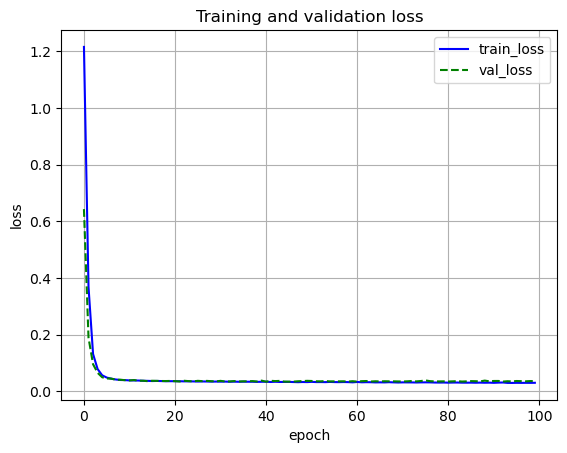

In [13]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [14]:
#save model
torch.save(model.state_dict(), '../saved_models/LSTM_env1_extract.pth')

In [14]:
#read model
model = LSTM(input_size, hidden_size, output_size, output_seq_length, num_layers).to(device)
model.load_state_dict(torch.load('../saved_models/LSTM_env1.pth'))
print(model)

LSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [15]:
class TestDataset(Dataset):
    def __init__(self, test_data):
        self.test_data = test_data

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, index):
        input = torch.tensor(self.test_data[index], dtype=torch.float32)
        output = 0
        return input, output

初期姿勢：-20°, 終端姿勢：-75°


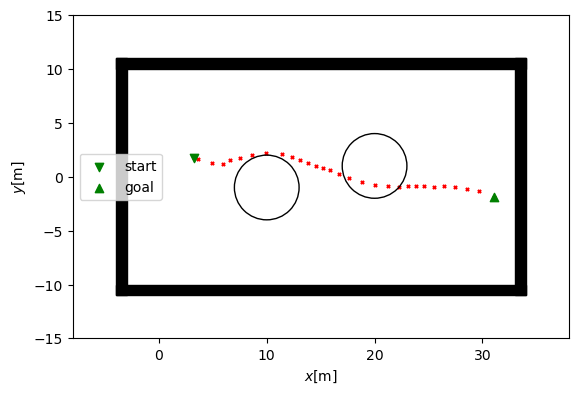

In [41]:
#test_pathの表示
import plot
import random

#入力のサンプリング
x_start = (random.uniform(-2, 4), random.uniform(-3, 3))  # Starting node
x_goal = (random.uniform(26, 32), random.uniform(-3, 3))  # Goal node

#env1用
theta_start = random.uniform(-np.pi/2, np.pi/2)
theta_goal = random.uniform(-np.pi/2, np.pi/2)
"""
#env2用
theta_start = random.uniform(np.pi/4, np.pi*3/4)
theta_goal = random.uniform(np.pi/4, np.pi*3/4)
"""
test_data = np.array([[[x_start[0], x_goal[0], x_start[1], x_goal[1], theta_start, theta_goal]]])

test_data = TestDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

#予測モード
model.eval()
with torch.no_grad():
    input_data, _ = next(iter(test_loader))
    input_data = input_data.to(device)
    output = model(input_data)


output = output.cpu().numpy()

test_x_path = np.array([])
test_y_path = np.array([])
for i in range(output.shape[1]):
    test_x_path = np.append(test_x_path, output[0, i, 0])
    test_y_path = np.append(test_y_path, output[0, i, 1])
    
test_x_path = np.append(test_x_path, x_goal[0])
test_x_path = np.append(x_start[0], test_x_path)
test_y_path = np.append(test_y_path, x_goal[1])
test_y_path = np.append(x_start[1], test_y_path)

print("初期姿勢：{}°, 終端姿勢：{}°".format(int(np.degrees(theta_start)), int(np.degrees(theta_goal))))
plot.vis_path_env1(test_x_path, test_y_path)